In [266]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
import logging


In [267]:
def setup_logger(logging_level):
    logger = logging.getLogger(__name__)
    logger.setLevel(logging_level)
    handler = logging.StreamHandler()
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)
    return logger
logging_level = 'INFO'
LOGGER = setup_logger(logging_level)


In [268]:
# ... existing code ...

# Replace the argparse code with this:
class Args:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

    def __repr__(self):
        return str(self.__dict__)

# Define default arguments
args = Args(
    dataset_name="mnist",
    hidden_dim=1024,
    latent_dim=100,
    lr=0.0001,
    epochs=20
)

# You can modify these values directly in the notebook
# args.dataset_name = "mnist"
# args.epochs = 10

print(args)

# ... existing code ...

{'dataset_name': 'mnist', 'hidden_dim': 1024, 'latent_dim': 100, 'lr': 0.0001, 'epochs': 20}


In [269]:
class VAE(nn.Module):
    def __init__(self, input_channels, img_size, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        # encoder
        self.fc1 = nn.Linear(input_channels * img_size * img_size   , hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        # decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_channels * img_size * img_size)
        
        
    def encode(self, x):
        e = F.relu(self.fc1(x))
        e = F.relu(self.fc2(e))
        return self.fc_mean(e), self.fc_logvar(e)
    
    def decode(self, z):
        d = F.relu(self.fc3(z))
        d = torch.sigmoid(self.fc4(d))
        return d
    
    def reparametrize(self, mean, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparametrize(mean, logvar)
        return self.decode(z), mean, logvar
    
    def loss_function(self, x, x_recon, mean, logvar):
        BCE = F.binary_cross_entropy(x_recon, x, reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
        return KLD + BCE, KLD, BCE



In [270]:

dataset_name = 'cifar10'
def setup_vae(dataset_name, hidden_dim, latent_dim, lr=0.001):
    if dataset_name == 'mnist':
        input_channels = 1
        img_size = 28
    elif dataset_name == 'fashion_mnist':
        input_channels = 1
        img_size = 28
    elif dataset_name == 'cifar10':
        input_channels = 3
        img_size = 32
    else:
        raise ValueError("Invalid dataset name")
    
    model = VAE(input_channels, img_size, hidden_dim, latent_dim)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    return model, optimizer, input_channels, img_size


def get_device():
    # mps
    if torch.backends.mps.is_available():
        device = torch.device('mps')
    else:
        device = torch.device('cpu')
    return device

dataset_name = args.dataset_name
hidden_dim = args.hidden_dim
latent_dim = args.latent_dim
lr = args.lr
epochs = args.epochs

model, optimizer, input_channels, img_size = setup_vae(dataset_name, hidden_dim, latent_dim, lr)

device = get_device()
model.to(device)


VAE(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc_mean): Linear(in_features=1024, out_features=100, bias=True)
  (fc_logvar): Linear(in_features=1024, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)

In [271]:
def data_loader(dataset_name, img_size):        
    if dataset_name == 'mnist':
        train_loader = torch.utils.data.DataLoader(
            datasets.MNIST('../../data', train=True, download=True, 
                       transform=transforms.Compose([transforms.Resize(img_size),
                                                     transforms.ToTensor()])),
            batch_size=64, shuffle=True
            )
    elif dataset_name == 'fashion_mnist':
        train_loader = torch.utils.data.DataLoader(
            datasets.FashionMNIST('../../data', train=True, download=True, 
                       transform=transforms.Compose([transforms.Resize(img_size),
                                                     transforms.ToTensor()])),
            batch_size=64, shuffle=True
            )
    elif dataset_name == 'cifar10':
        train_loader = torch.utils.data.DataLoader(
            datasets.CIFAR10('../../data', train=True, download=True, 
                       transform=transforms.Compose([transforms.Resize(img_size),
                                                     transforms.ToTensor()])),
            batch_size=64, shuffle=True
            )
    else:
        raise ValueError("Invalid dataset name")
    return train_loader

train_loader = data_loader(dataset_name, img_size) 



In [272]:
print(3*32*32)
print(64*32*32*3)


3072
196608


In [273]:

def train(model, input_channels, img_size, optimizer, epochs, train_loader, device):
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            LOGGER.debug(data.shape)
            LOGGER.debug(input_channels * img_size * img_size)
            data = data.view(-1, input_channels * img_size * img_size)
            LOGGER.debug(data.shape)
            optimizer.zero_grad()
            x_recon, mean, logvar = model(data)

            loss, kld, bce = model.loss_function(data, x_recon, mean, logvar)
            loss.backward()
            optimizer.step()
        average_loss = loss.item() / len(train_loader.dataset)
        average_kld = kld.item() / len(train_loader.dataset)
        average_bce = bce.item() / len(train_loader.dataset)
        print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {average_loss}, KLD: {average_kld}, BCE: {average_bce}')

train(model, input_channels, img_size, optimizer, epochs, train_loader, device)

Epoch [1/20], Average Loss: 0.08446730143229167, KLD: 0.00967815450032552, BCE: 0.07478914388020834
Epoch [2/20], Average Loss: 0.0778560546875, KLD: 0.011273124186197917, BCE: 0.0665829345703125
Epoch [3/20], Average Loss: 0.07090829264322916, KLD: 0.012141900634765624, BCE: 0.05876639404296875
Epoch [4/20], Average Loss: 0.07438375651041666, KLD: 0.012041885375976563, BCE: 0.0623418701171875
Epoch [5/20], Average Loss: 0.06721056315104167, KLD: 0.012780120849609375, BCE: 0.0544304443359375
Epoch [6/20], Average Loss: 0.065208837890625, KLD: 0.013173234049479166, BCE: 0.05203560384114583
Epoch [7/20], Average Loss: 0.06310811360677084, KLD: 0.013191864013671875, BCE: 0.049916251627604165
Epoch [8/20], Average Loss: 0.0611372314453125, KLD: 0.013670846557617187, BCE: 0.047466385904947915
Epoch [9/20], Average Loss: 0.062489404296875, KLD: 0.014223779296875, BCE: 0.048265625
Epoch [10/20], Average Loss: 0.0594197998046875, KLD: 0.013358383178710938, BCE: 0.046061417643229165
Epoch [11/2

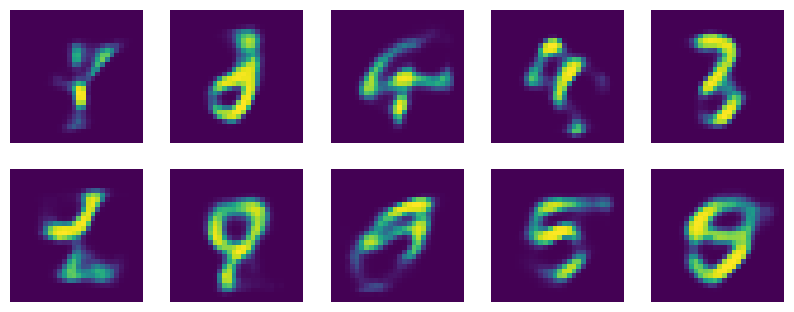

In [280]:
def generate_images(model, device, img_size, input_channels, num_images=10):
    model.eval()
    with torch.no_grad():
        noise = torch.randn(num_images, 100).to(device)
        images = model.decode(noise)
        images = images.view(num_images, input_channels, img_size, img_size)
    
    # plot in grid square   
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(5, 5, i+1)
        img = images[i].cpu().numpy().transpose(1, 2, 0)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

# Call the function with correct parameters
generate_images(model, device, img_size, input_channels, 10)

torch.Size([64, 3, 32, 32])
(3, 32, 32)


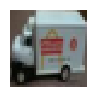

In [117]:

from random import randint
import numpy as np

data = next(iter(train_loader))
print(data[0].shape)

# Randomly select an image
random_index = randint(0, data[0].shape[0] - 1)

# Get the selected image and convert it to numpy array
img = data[0][random_index].cpu().numpy()
print(img.shape)

# Transpose the image to (height, width, channels)
img = np.transpose(img, (1, 2, 0))

# Normalize the image if necessary (CIFAR-10 images are already normalized)
# img = np.clip(img, 0, 1)

plt.figure(figsize=(1, 1))  # Set a smaller figure size
plt.imshow(img, interpolation='nearest')  # Use nearest neighbor interpolation to avoid blurring
plt.axis('off')
plt.show()

